In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json, csv
plt.style.use('bmh')
#plt.style.use('seaborn-ticks')

# Necessary modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import module and function for CPC data extraction
from Module_CPC import *

# import functions for FTIR extraction and analysis
from Module_FTIR import All_Absorbance_Analysis, ShoowAllCorrectedAbsorbances

# For Image Analysis
from RGB_Collection_area import GetDiameterFromImage

# For final computation for aeral densities 
from Module_Computations import Particles2Absorbances

# Initial Elements

In [4]:
# Get the base folder for the compound
data_path = os.path.join("Data", "AmmOx")
if not os.path.exists(data_path) or not os.path.isdir(data_path):
    raise NotADirectoryError(f"Data path is not a valid directory: {data_path}")

# Folder for the CPC files 
CPC_folder_path = os.path.join(data_path, "CPCData")
if not os.path.exists(CPC_folder_path) or not os.path.isdir(CPC_folder_path):
    raise NotADirectoryError(f"CPCData folder is not a valid directory: {CPC_folder_path}")

# Folder for the FTIR files
FTIR_folder_path = os.path.join(data_path, "FTIRData")
if not os.path.exists(FTIR_folder_path) or not os.path.isdir(FTIR_folder_path):
    raise NotADirectoryError(f"FTIRData folder is not a valid directory: {FTIR_folder_path}")

# Folder for the outputs
output_folder = os.path.join(data_path, "OUTPUT")
if not os.path.exists(output_folder) or not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# Excel File regrouping all informations on experiences

In [5]:
excel_filename = "AmmOxSamples.xlsx"
exp_excel_path = os.path.join(data_path, excel_filename)
if not os.path.exists(exp_excel_path) or not os.path.isfile(exp_excel_path):
    raise FileNotFoundError(f"Samples file does not exist: {exp_excel_path}")

In [6]:
exp_excel = pd.read_excel(exp_excel_path)
exp_excel

Sample Material   dia  ...              Frog_File  Frog_start  Frog_stop
0        1     ZnSe  2000  ...  20230516AMMOXEXPS.txt        1min      19min
1        1     ZnSe  2000  ...  20230516AMMOXEXPS.txt        1min      19min
2        1     ZnSe  2000  ...  20230516AMMOXEXPS.txt        1min      19min
3        1     ZnSe  2000  ...  20230516AMMOXEXPS.txt        1min      19min
4        1     ZnSe  2000  ...  20230516AMMOXEXPS.txt        1min      19min
..     ...      ...   ...  ...                    ...         ...        ...
67       6     ZnSe  2000  ...  20230516AMMOXEXPS.txt        2h64       3h16
68       6     ZnSe  2000  ...  20230516AMMOXEXPS.txt        2h65       3h17
69       6     ZnSe  2000  ...  20230516AMMOXEXPS.txt        2h66       3h18
70       6     ZnSe  2000  ...  20230516AMMOXEXPS.txt        2h67       3h19
71       6     ZnSe  2000  ...  20230516AMMOXEXPS.txt        2h68       3h20

[72 rows x 16 columns]

In [7]:
# check for consistency
if len(exp_excel["dia"].unique())>1:
    print("Expected only 1 diameter")
elif len(exp_excel["M"].unique())>1:
    print("Expected only 1 mass")
elif len(exp_excel["rho"].unique())>1:
    print("Expected only 1 rho")
else:
    print("Ok..")

Ok..


----
# Computation of the CPC Analysis

In [8]:
exp=3
rows = exp_excel[exp_excel["Sample"]==exp]

filename_array =rows["AIM_file"].unique()
start_exp = rows["cut_lower"].unique()
end_exp = rows["cut_upper"].unique()

AmmSulCPCFile = CPC_File(filename = os.path.join(CPC_folder_path,filename_array[-1]))

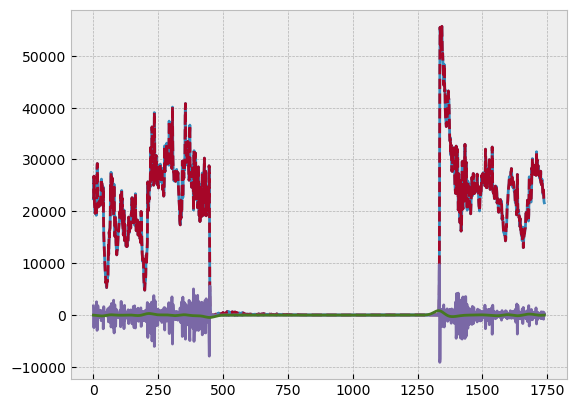

In [10]:
ExpConc = AmmSulCPCFile.extract_experiment_conc(start_sample=start_exp, end_sample=end_exp)
plt.plot(ExpConc)
conc_x = np.arange(len(ExpConc))
conc_spl = UnivariateSpline(conc_x, ExpConc)
plt.plot(conc_spl(conc_x), '--')
conc_grad = np.gradient(conc_spl(conc_x))
plt.plot(np.gradient(conc_grad))
#smoothed_data = np.convolve(ExpConc, np.ones(3), mode="valid")
smoothed_data = gaussian_filter1d(ExpConc, sigma=20)
plt.plot(np.gradient(smoothed_data))

More than 1 peak found, taking the strongest one
More than 1 peak found, taking the strongest one


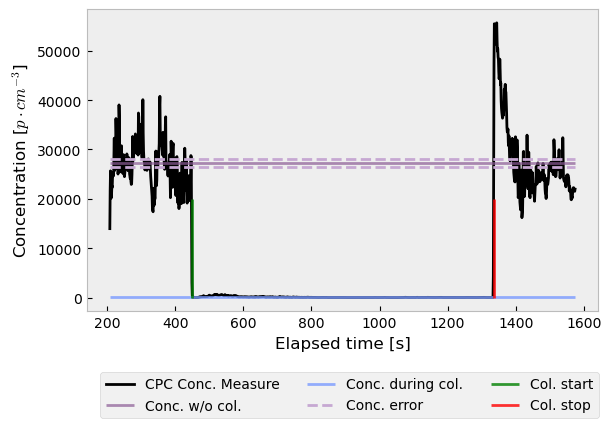

(26530.0,
 28086.846473029047,
 27308.42323651452,
 778.4232365145235,
 154.608490990991,
 887)

In [11]:
AnalyseExpConcTruncated(ExpConc, peak_height=1500, expName = 'Noname', output_folder = output_folder, vline_height = 20000)

In [ ]:
# variable to avoid unecessary repetitive data extraction
old_filename = None

for exp in exp_excel["Sample"].unique():
    print(f"Processing experiment {exp}........")
    rows = exp_excel[exp_excel["Sample"]==exp]

    filename_array =rows["AIM_file"].unique()
    start_exp = rows["cut_lower"].unique()
    end_exp = rows["cut_upper"].unique()

    if len(filename_array)>1:
        print(f"error, filename not unique for exp {exp}")
    else :
        filename = os.path.join(CPC_folder_path,filename_array[0])
    if len(start_exp)>1:
        print(f"error, lower cut number not correct for exp {exp}")
    else:
        start_exp = start_exp[0]
    if len(end_exp)>1:
        print(f"error, upper cut number not correct for exp {exp}")
    else:
        end_exp = end_exp[0]

    if not filename==old_filename:
        AmmSulCPCFile = CPC_File(filename)
        old_filename = filename

    ExpConc = AmmSulCPCFile.extract_experiment_conc(start_sample=start_exp, end_sample=end_exp)
    C_before, C_after, C_base, C_error, C_collection, C_time = AnalyseExpConcTruncated(ExpConc, peak_height=1500, expName = "Exp"+str(exp), output_folder = output_folder)

    results = {'Filename': filename,
               'Experiment Number': exp,
               'Start sample': start_exp,
               'End sample': end_exp,
               'Concentration before': C_before,
               'Concentration after': C_after,
               'Concentration base (mean)': C_base,
               'Concentration error (deviation)': C_error,
               'Concentration collection (mean)': C_collection,
               'Collection time (sec)': C_time,
               'Total collection (part per cm3)': (C_base-C_collection)*C_time,
               'Total collection error (part per cm3)': C_error * C_time}

    # Open a new CSV file for writing
    with open(os.path.join(output_folder,f'Exp{exp}CPCMeasuresResults.csv'), 'w', newline='') as csvfile:
        # Define the field names for the CSV file
        fieldnames = list(results.keys())

        # Create a writer object for the CSV file and write the header row
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Write the data rows to the CSV file
        writer.writerow(results)

# FTIR extraction and Analysis

In [ ]:
All_Absorbance_Analysis(excel_file=exp_excel_path, data_path=FTIR_folder_path, output_folder=output_folder, peak_locations=[1500, 3000], peak_height=0.01, distance_between_peaks=200)

In [ ]:
nist_file = os.path.join("Data","NIST", "ammonium_oxalate.csv")
ShoowAllCorrectedAbsorbances(excel_datafrane=exp_excel, output_folder_path=output_folder, nist_filepath=nist_file)

# Computation of the measure related to absorbance

### To run to update the computed values of areal mass density and absorbances 

In [ ]:
data_dict = Particles2Absorbances(exp_excel, data_path=data_path, output_folder=output_folder)

### To run to get the values

In [ ]:
aerial_density_json_filepath = os.path.join(output_folder, "ParticlesAndAbsorbances.json")
if not os.path.exists(aerial_density_json_filepath):
    raise NotADirectoryError(f"json file not valid directory: {aerial_density_json_filepath}")

with open(aerial_density_json_filepath) as json_file:
    data_dict = json.load(json_file)

Masses = np.array(data_dict["Masses"])
Masses_error = np.array(data_dict["Masses_error"])
N_as = np.array(data_dict["N_as"])
N_as_error = np.array(data_dict["N_as_error"])
Exps = np.array(data_dict["Exps"])

peaks_wv = np.loadtxt(os.path.join(output_folder,"PeaksWavelengthsArray.csv"), delimiter=',')
peaks_abs = np.loadtxt(os.path.join(output_folder, "PeaksAbsorbanceArray.csv"), delimiter=',')

# Full linear regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Input data with errors
x_data =N_as# Estimated thickness with errors
x_ref = np.linspace(np.min(x_data), np.max(x_data), 100) # some more values to fit regression
x_error = N_as_error # Error in x-axis measurements

colors_list  = ['#8e395c', '#104fa4', '#5c8e39']
colors_errorbars = ["#642631", "#263164", "#316426"]


# Linear regression for y_data i 
fig, ax = plt.subplots(1,1,figsize=(8,7), dpi=300)
for peak_num in range(peaks_wv.shape[1]):
    
    peak_i = np.mean(peaks_wv[:,peak_num])
    y_data = peaks_abs[:,peak_num]

    slope, intercept, r_value, p_value, std_err = linregress(np.append(x_data,0), np.append(y_data,0))
    print(f"{peak_num} Peak: {peak_i:.0f} cm-1: Y = {slope:.3f}*x + {intercept:.3e}")
    y_fit = slope * x_ref + intercept
    y_error_min = y_fit - std_err * x_ref
    y_error_max = y_fit + std_err * x_ref

    # Experiments
    if peak_num == 0:
        plt.errorbar(x_data, y_data, xerr=x_error,capsize=3, fmt='o', label='Experiments', color = colors_errorbars[peak_num])
    else : 
        plt.errorbar(x_data, y_data, xerr=x_error,capsize=3, fmt='o', color = colors_errorbars[peak_num])
    # Annotation
    if peak_num != 2:
        for i,exp in enumerate(Exps):
            plt.annotate('Exp.'+str(exp),[1*x_data[i],0.002 + y_data[i]], xycoords = 'data', color = colors_errorbars[peak_num])
    # Linear regression
    plt.plot(x_ref, y_fit,label=f'Peak {peak_i:.0f} [cm-1] fit: R2 = {r_value**2:.3f}', color = colors_list[peak_num] )
    #plt.plot(x_ref, y2_error_min, dashes= [6,6], alpha=0.5, color = '#CBA8FF', label = '95% Prediction Interval')
    #plt.plot(x_ref, y2_error_max, dashes = [6, 6], alpha=0.5, color = '#CBA8FF')
    plt.fill_between(x_ref, y_fit - std_err * x_ref, y_fit + std_err * x_ref, color = colors_list[peak_num], alpha=0.1)


    MolarMass = exp_excel["M"].unique()[-1]
    rho = exp_excel["rho"].unique()[-1]

    MeasAttenuationCoeff_1 = slope * MolarMass / rho / 1000
    MeasStd_1 = std_err * MolarMass / rho / 1000
    print(f"molar absorption coefficient: {MeasAttenuationCoeff_1:.1f} +/- {MeasStd_1:.1f}")
    
plt.minorticks_on()
plt.grid(True, which="major")
#plt.grid(True, which='major', linestyle = '-', )
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.xlabel(r'$m_a^*(r_b)/\rho \quad$ [cm]')
plt.ylabel('Absorbance [a.u.]')
plt.legend()

plt.savefig(os.path.join(output_folder,f"LinReg_peaks_all.png"), dpi=200, bbox_inches='tight')
plt.show()

# Peaks median and deviation

In [ ]:
m_peak1, std_peak1= np.median(peaks_wv[:,0]), np.std(peaks_wv[:,0])
m_peak2, std_peak2 = np.median(peaks_wv[:,1]), np.std(peaks_wv[:,1])
print(m_peak1, std_peak1, std_peak1/m_peak1 * 100)
print(m_peak2, std_peak2, std_peak2/m_peak2 * 100)

peaks_wv

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,1.2))

axs[0].boxplot(peaks_wv[:,0],vert = False, widths=0.5)
axs[0].set_title(f"Peak CO")
axs[0].set_xlabel("Wavenumber [cm-1]")
axs[0].set_yticks([])
axs[1].boxplot(peaks_wv[:,1], vert = False, widths=0.5)
axs[1].set_title(f"Peak NH")
axs[1].set_xlabel(f"Wavenumber [cm-1]")
axs[1].set_yticks([])

plt.savefig(os.path.join(output_folder, f"Boxplot_AmmOx.png"), dpi=200, bbox_inches='tight')